In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
filename = "/kaggle/input/flight-delays-dataset/flight_delays.csv"
df = pd.read_csv(filename)

In [30]:
df.head()

,FlightID,Airline,FlightNumber,Origin,Destination,ScheduledDeparture,ActualDeparture,ScheduledArrival,ActualArrival,DelayMinutes,DelayReason,Cancelled,Diverted,AircraftType,TailNumber,Distance
0,1,United,4558,ORD,MIA,2024-09-01 08:11,2024-09-01 08:30,2024-09-01 12:11,2024-09-01 12:19,8,Weather,True,False,Boeing 737,N71066,1031
1,2,Delta,8021,LAX,MIA,2024-09-01 10:25,2024-09-01 10:41,2024-09-01 13:25,2024-09-01 13:27,2,Air Traffic Control,True,True,Airbus A320,N22657,1006
2,3,Southwest,7520,DFW,SFO,2024-09-01 16:53,2024-09-01 17:05,2024-09-01 17:53,2024-09-01 18:07,14,Weather,True,True,Boeing 737,N95611,2980
3,4,Delta,2046,ORD,BOS,2024-09-01 14:44,2024-09-01 15:04,2024-09-01 18:44,2024-09-01 18:34,-10,NaN,False,False,Boeing 777,N90029,1408
4,5,Delta,6049,LAX,SEA,2024-09-01 01:51,2024-09-01 02:08,2024-09-01 05:51,2024-09-01 06:15,24,Air Traffic Control,False,True,Boeing 737,N27417,2298


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747627 entries, 0 to 1747626
Data columns (total 16 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   FlightID            int64 
 1   Airline             object
 2   FlightNumber        int64 
 3   Origin              object
 4   Destination         object
 5   ScheduledDeparture  object
 6   ActualDeparture     object
 7   ScheduledArrival    object
 8   ActualArrival       object
 9   DelayMinutes        int64 
 10  DelayReason         object
 11  Cancelled           bool  
 12  Diverted            bool  
 13  AircraftType        object
 14  TailNumber          object
 15  Distance            int64 
dtypes: bool(2), int64(4), object(10)
memory usage: 190.0+ MB


In [32]:
# Eksik verileri kontrol etme
print(df.isnull().sum())

# Kategorik verileri one-hot encoding ile dönüştürme
df_encoded = pd.get_dummies(df, columns=['Airline', 'Origin', 'Destination', 'DelayReason', 'AircraftType'])

FlightID                   0
Airline                    0
FlightNumber               0
Origin                     0
Destination                0
ScheduledDeparture         0
ActualDeparture            0
ScheduledArrival           0
ActualArrival              0
DelayMinutes               0
DelayReason           468873
Cancelled                  0
Diverted                   0
AircraftType               0
TailNumber                 0
Distance                   0
dtype: int64


**Birçok delayReason kısmının boş olduğunu fark ettim, çok fazla değer olmasaydı eksik verileri kaldırmayı deneyecektim ancak bu kadar çok veriyi kaybetmek istemediğimden dolayı en yaygın DelayReason neyse boş olanları onla doldurmaya karar verdim.**

In [33]:
# En sık görülen gecikme nedenini bulma
most_common_delay_reason = df['DelayReason'].mode()[0]

# Eksik değerleri en yaygın gecikme nedeni ile doldurma
df['DelayReason'] = df['DelayReason'].fillna(most_common_delay_reason)

**Tekrardan null değerleri kontrol ediyorum.**

In [34]:
# Eksik verileri kontrol etme
print(df.isnull().sum())

FlightID              0
Airline               0
FlightNumber          0
Origin                0
Destination           0
ScheduledDeparture    0
ActualDeparture       0
ScheduledArrival      0
ActualArrival         0
DelayMinutes          0
DelayReason           0
Cancelled             0
Diverted              0
AircraftType          0
TailNumber            0
Distance              0
dtype: int64


**Null değerlerden kurtuldum, sonucumu bir miktar değiştirecek de olsa en gerçekçi çözüm için bunu yapmam gerekiyordu.**

In [35]:
df['ScheduledDeparture'] = pd.to_datetime(df['ScheduledDeparture'])
df['ActualDeparture'] = pd.to_datetime(df['ActualDeparture'])
df['ScheduledArrival'] = pd.to_datetime(df['ScheduledArrival'])
df['ActualArrival'] = pd.to_datetime(df['ActualArrival'])

# Datetime sütunlarını bileşenlerine ayırma
df['ScheduledDeparture_Year'] = df['ScheduledDeparture'].dt.year
df['ScheduledDeparture_Month'] = df['ScheduledDeparture'].dt.month
df['ScheduledDeparture_Day'] = df['ScheduledDeparture'].dt.day
df['ScheduledDeparture_Hour'] = df['ScheduledDeparture'].dt.hour
df['ScheduledDeparture_Minute'] = df['ScheduledDeparture'].dt.minute

df['ActualDeparture_Year'] = df['ActualDeparture'].dt.year
df['ActualDeparture_Month'] = df['ActualDeparture'].dt.month
df['ActualDeparture_Day'] = df['ActualDeparture'].dt.day
df['ActualDeparture_Hour'] = df['ActualDeparture'].dt.hour
df['ActualDeparture_Minute'] = df['ActualDeparture'].dt.minute

# Gecikme sürelerini hesaplama
df['DepartureDelay'] = (df['ActualDeparture'] - df['ScheduledDeparture']).dt.total_seconds() / 60.0  # dakika cinsinden
df['ArrivalDelay'] = (df['ActualArrival'] - df['ScheduledArrival']).dt.total_seconds() / 60.0

# Gereksiz datetime sütunlarını düşürme
df = df.drop(columns=['ScheduledDeparture', 'ActualDeparture', 'ScheduledArrival', 'ActualArrival'])


# SUPERVISED LEARNING (GÖZETİMLİ ÖĞRENME)

**Hangi Gözetimli Öğrenme yöntemini kullanmam gerektiği konusunda bir miktar araştırma yaptım ve hem benim için çok karmaşık olmayacak hem de sonucu daha sağlıklı bulabileceğim bir yöntem izlemeye çalıştım. Random Forest Regressor yani Rastgele Orman Regresyonunu kullanmaya karar verdim.**

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

**Gerekli kütüphaneleri üstte import ettikten sonra bağımlı ve bağımsız değişkenlerimi belirledim.
* Bağımlı değişken yani hedef(target) = Gecikme Süresi
* Bağımsız değişkenlerim ise gecikme süresini etkileyecek etmenler.**

In [37]:
# Hedef değişken (target)
y = df['DelayMinutes']

# Bağımsız değişkenler (features) - olmayan sütunları listeden çıkaralım
X = df.drop(['FlightID', 'DelayMinutes', 'TailNumber'], axis=1)

# Kategorik değişkenlerin sayısallaştırılması
X = pd.get_dummies(X)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
# Random Forest modelini oluşturma
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Modeli eğitme
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [40]:
# Test seti üzerinde tahmin yapma
y_pred = model.predict(X_test)

# Performans değerlendirme - Ortalama mutlak hata (MAE) ve R-kare (R2) skoru
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 0.0
R2 Score: 1.0


In [41]:
# Özellik önemini elde etme
feature_importances = model.feature_importances_

# Özelliklerin isimleriyle birlikte gösterme
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# En önemli özellikleri sıralayarak gösterme
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                            Feature  Importance
15                     ArrivalDelay         1.0
0                      FlightNumber         0.0
19                   Airline_United         0.0
21                       Origin_DFW         0.0
22                       Origin_JFK         0.0
23                       Origin_LAX         0.0
24                       Origin_ORD         0.0
25                  Destination_BOS         0.0
26                  Destination_JFK         0.0
27                  Destination_MIA         0.0
28                  Destination_SEA         0.0
29                  Destination_SFO         0.0
30  DelayReason_Air Traffic Control         0.0
31          DelayReason_Maintenance         0.0
32              DelayReason_Weather         0.0
33         AircraftType_Airbus A320         0.0
34          AircraftType_Boeing 737         0.0
20                       Origin_ATL         0.0
18                Airline_Southwest         0.0
1                         Cancelled     

**Gerçek ve tahmin edilen değerlerin grafik üzerinde gösterilmesi:**

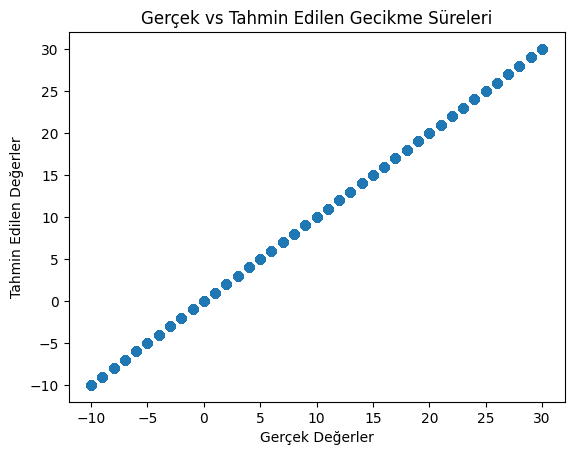

In [42]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title('Gerçek vs Tahmin Edilen Gecikme Süreleri')
plt.show()

# UNSUPERVISED LEARNING (GÖZETİMSİZ ÖĞRENME)

**Bir de gözetimsiz öğrenme yöntemlerden birini denemek istiyorum. Birçok gözetimsiz öğrenme yöntemleri arasında açıkçası benim için en anlaşılır olan K-Means Kümeleme yöntemini kullanmaya karar verdim.**

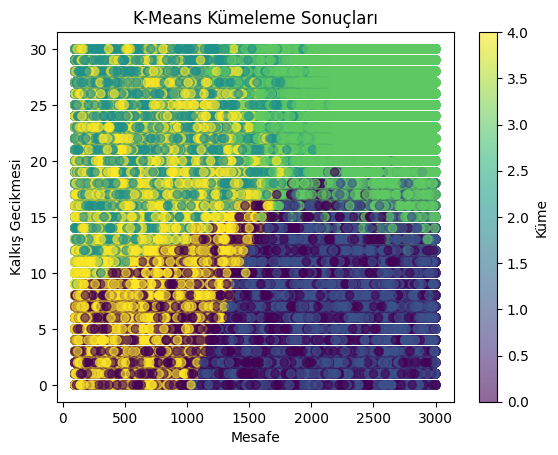

Silhouette Score: 0.2558279847475432
Inertia: 2096011.6602328971


In [45]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Kümeleme sonuçlarını görselleştirme
plt.scatter(df['Distance'], df['DepartureDelay'], c=df['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Mesafe')
plt.ylabel('Kalkış Gecikmesi')
plt.title('K-Means Kümeleme Sonuçları')
plt.colorbar(label='Küme')
plt.show()

# Performans değerlendirme: Alt küme ile (İşlem uzun sürdüğünden dolayı alt küme kullandım)
sample_size = 1000  # Alt küme boyutu
if X_scaled.shape[0] > sample_size:
    np.random.seed(42)
    sample_indices = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
    X_sample = X_scaled[sample_indices]
    cluster_sample = df['Cluster'].iloc[sample_indices]
    score = silhouette_score(X_sample, cluster_sample)
else:
    score = silhouette_score(X_scaled, df['Cluster'])

print(f'Silhouette Score: {score}')

# Alternatif performans ölçüsü: Inertia
inertia = kmeans.inertia_
print(f'Inertia: {inertia}')

* Kümeleme sonuçlarını yorumlamak için grafikler oluşturacağım.

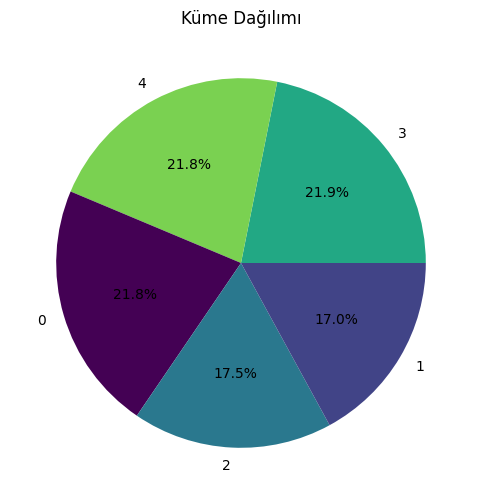

In [46]:
# Küme sayısına göre her bir kümenin oranını hesaplayın
cluster_counts = df['Cluster'].value_counts()

# Pasta grafiği oluşturma
plt.figure(figsize=(8, 6))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', colors=plt.cm.viridis(cluster_counts.index / len(cluster_counts.index)))
plt.title('Küme Dağılımı')
plt.show()

# Performans Doğrulama : K-Fold Çaprazlama

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Veri setinin bir alt kümesini oluşturma
df_small = df.sample(frac=0.1, random_state=42)  # Verinin %10'unu seç

# Bağımsız ve bağımlı değişkenleri yeniden tanımlama
X_small = df_small.drop(['FlightID', 'DelayMinutes', 'TailNumber'], axis=1)
y_small = df_small['DelayMinutes']

# Kategorik değişkenlerin sayısallaştırılması
X_small = pd.get_dummies(X_small)

# Model oluşturma
model = RandomForestRegressor(n_estimators=100, random_state=42)

# K-Fold çapraz doğrulama
cv_scores = cross_val_score(model, X_small, y_small, cv=5, scoring='neg_mean_absolute_error')

# Negatif MAE değerlerini pozitif hale getirme ve ortalama MAE'yi hesaplama
mean_cv_score = np.mean(-cv_scores)

print(f"Mean Absolute Error (MAE) from Cross-Validation: {mean_cv_score}")

Mean Absolute Error (MAE) from Cross-Validation: 0.0


# MAE Nedir?

Ortalama Mutlak Hata (MAE), bir modelin tahminlerinin doğruluğunu ölçen bir performans metriğidir. MAE, tahminler ile gerçek değerler arasındaki mutlak farkların ortalamasını hesaplar. Bu ölçüm, modelin tahminlerinin ne kadar doğru olduğunu veya hata payını anlamak için kullanılır

# MAE'nin Artıları ve Eksileri
**Artıları:**

* Basitlik: Hesaplaması ve yorumlanması kolaydır.
* Doğrudan Anlam: Gerçek hata büyüklüğünü doğrudan gösterir.

**Eksileri:**

* Hatalara Eşit Ağırlık: MAE, büyük hataları küçük hatalardan ayırt etmez. Bu durum, hata dağılımı açısından detaylı bilgi vermez.

**Modelin mükemmel tahminler yapması genelde çok nadir olurmuş internette arattığımda böyle bir sonuca vardım. Modelde bir problem olduğunu gösterme ihtimali yüksekmiş ancak ben bu süre zarfında projenin bu kısmına gelebilecek kadar çalışma yürütebildim.**